# IMPORT LIBRARY

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import os
import time
import cv2
import pathlib
import matplotlib as mpl

In [ ]:
img_width = 448
img_height = 448
batch_size = 64
color = 3
path = '/content/drive/MyDrive/deep learning'
path_extract = os.path.join(path, "wildfire.zip")

#INSTALL DATASET USED IN OUR PROJECT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile(path_extract,"r") as z:
    z.extractall(".")

#SHOW DATASET IMAGES

In [ ]:
names = []
nums = []
data = {'Name of class':[],'Number of samples':[]}

for i in os.listdir('forest_fire/Training and Validation/'):
    nums.append(len(os.listdir('forest_fire/Training and Validation/'+i)))
    names.append(i)

data['Name of class']+=names
data['Number of samples']+=nums

df = pd.DataFrame(data)
df

,Name of class,Number of samples
0,nofire,904
1,fire,928


<Axes: xlabel='Name of class', ylabel='Number of samples'>

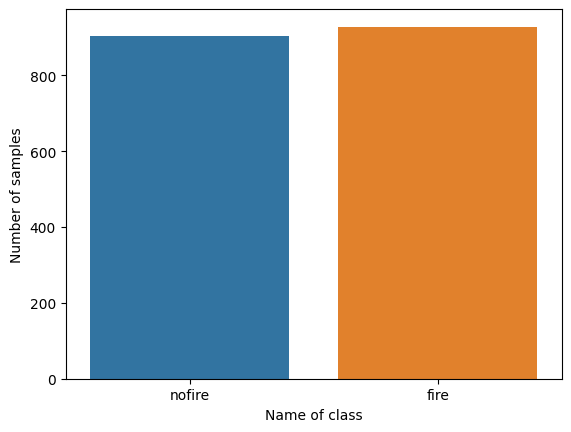

In [ ]:
sns.barplot(x=df['Name of class'],y=df['Number of samples'])

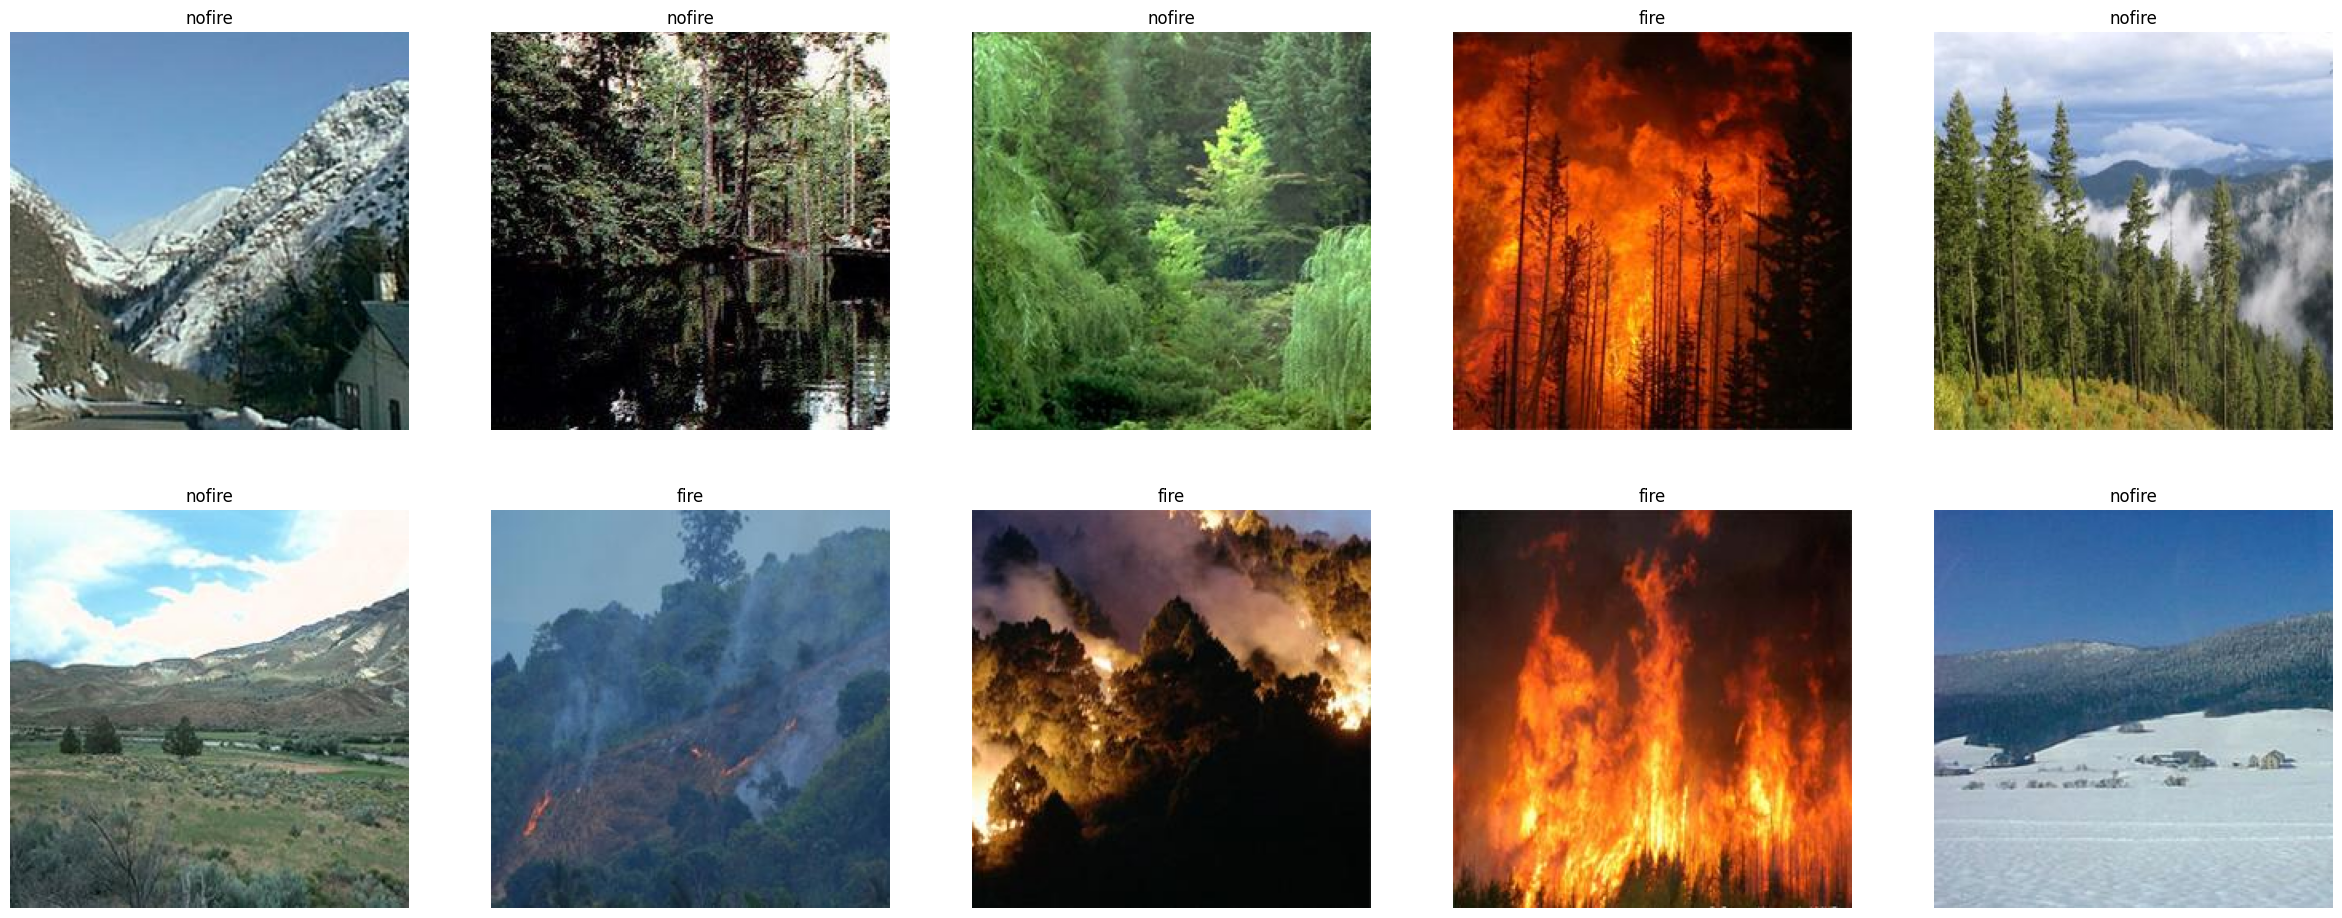

In [ ]:
classes = os.listdir('forest_fire/Training and Validation/')

plt.figure(figsize=(30 , 30))
for x in range(10):
    i = random.randint(0,1)                    # getting the class
    images = os.listdir('forest_fire/Training and Validation'+'/'+classes[i])
    j = random.randint(0,100)                  # getting the image
    image = cv2.imread('forest_fire/Training and Validation'+'/'+classes[i]+'/'+images[j])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(5, 5, x + 1)
    plt.imshow(image)
    plt.title(classes[i])
    plt.axis("off")

plt.show()

In [ ]:
def Blurring(image):
  image = cv2.medianBlur(image,5)
  return image
def image_generator(data):
  datagen = ImageDataGenerator( rescale=1/255, validation_split=0.1,vertical_flip=True ,horizontal_flip=True,width_shift_range=0.2,height_shift_range=0.2,
                               rotation_range = 5, shear_range = 0.02,zoom_range = 0.02, preprocessing_function = Blurring)
  train_generator = datagen.flow_from_directory(
      'forest_fire/Training and Validation/',
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=True,
      subset='training')
  validation_generator = datagen.flow_from_directory(
      'forest_fire/Training and Validation/',
      target_size=(img_height, img_width),
      batch_size= batch_size,
      shuffle=False,
      class_mode='categorical',
      subset='validation')
  return [train_generator, validation_generator]

In [ ]:
[training_dataset, validation_dataset] = image_generator(data)

Found 1650 images belonging to 2 classes.
Found 182 images belonging to 2 classes.


#Transfer Learning using mobilenet_v2

In [ ]:
mobilenetv2 = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, color))
model = keras.layers.Dropout(0.2)(mobilenetv2.output)
model = keras.layers.Flatten()(model)
model = keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(model)
model = keras.layers.Dropout(0.2)(model)
model = keras.layers.Dense(128, activation='relu',  kernel_regularizer=tf.keras.regularizers.L2(0.01))(model)
model = keras.layers.Dropout(0.2)(model)
model = keras.layers.Dense(64, activation='relu',  kernel_regularizer=tf.keras.regularizers.L2(0.01))(model)
model = keras.layers.Dropout(0.2)(model)
model = keras.layers.Dense(32, activation='relu',  kernel_regularizer=tf.keras.regularizers.L2(0.01))(model)
model = keras.layers.Dropout(0.2)(model)
model = keras.layers.Dense(16, activation='relu',  kernel_regularizer=tf.keras.regularizers.L2(0.01))(model)
model = keras.layers.Dropout(0.2)(model)
prediksi = keras.layers.Dense(len(classes), activation='softmax', activity_regularizer=tf.keras.regularizers.L2(0.01))(model)
model = keras.models.Model(inputs=mobilenetv2.input, outputs=prediksi)
for layer in model.layers[:151]:
    layer.trainable = False
for layer in model.layers[151:]:
    layer.trainable = True
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 448, 448, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 224, 224, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 224, 224, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 224, 224, 32)         0         ['bn_Conv1[0][0]']      

In [ ]:
len(model.layers)

167

In [ ]:
model.layers[151:]

In [ ]:
metric = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'),
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc')
]

In [ ]:
base_learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss="categorical_crossentropy",
              metrics=metric)

In [ ]:
epochs=20
history = model.fit(
  training_dataset,
  epochs=epochs,
  batch_size = batch_size
)

Epoch 1/20
26/26 [==============================] - 103s 3s/step - loss: 282.0855 - tp: 1155.0000 - fp: 495.0000 - tn: 1155.0000 - fn: 495.0000 - accuracy: 0.7000 - precision: 0.7000 - recall: 0.7000 - auc: 0.7216
Epoch 2/20
26/26 [==============================] - 90s 3s/step - loss: 55.7758 - tp: 1458.0000 - fp: 192.0000 - tn: 1458.0000 - fn: 192.0000 - accuracy: 0.8836 - precision: 0.8836 - recall: 0.8836 - auc: 0.9483
Epoch 3/20
26/26 [==============================] - 94s 4s/step - loss: 8.7299 - tp: 1545.0000 - fp: 105.0000 - tn: 1545.0000 - fn: 105.0000 - accuracy: 0.9364 - precision: 0.9364 - recall: 0.9364 - auc: 0.9814
Epoch 4/20
26/26 [==============================] - 91s 3s/step - loss: 4.1040 - tp: 1531.0000 - fp: 119.0000 - tn: 1531.0000 - fn: 119.0000 - accuracy: 0.9279 - precision: 0.9279 - recall: 0.9279 - auc: 0.9789
Epoch 5/20
26/26 [==============================] - 95s 4s/step - loss: 3.5649 - tp: 1571.0000 - fp: 79.0000 - tn: 1571.0000 - fn: 79.0000 - accuracy: 0

# Metrics

In [ ]:
def kurva(p1, p2, p3, p4):
  a = p1[0]
  b = p2[0]
  c = p3[0]
  d = p4[0]
  plt.figure(figsize = (20,4))
  plt.plot(a,'blue', label=p1[1])
  plt.plot(b,'orange', label=p2[1])
  plt.plot(c,'red', label=p3[1])
  plt.plot(d,'green', label=p4[1])
  plt.legend()

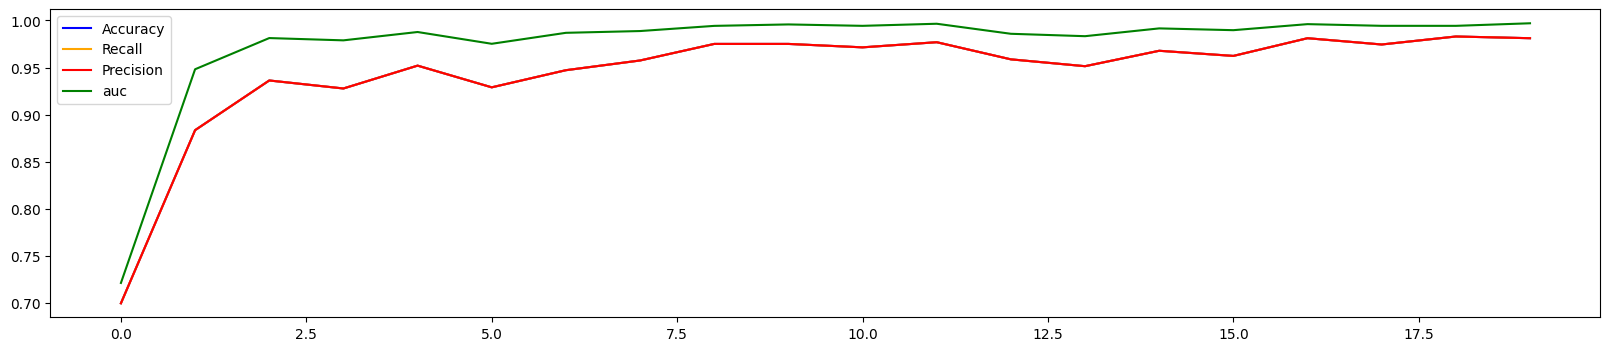

In [ ]:
kurva(
    [history.history['accuracy'], 'Accuracy'],
    [history.history['recall'], 'Recall'],
    [history.history['precision'], 'Precision'],
    [history.history['auc'], 'auc']
)

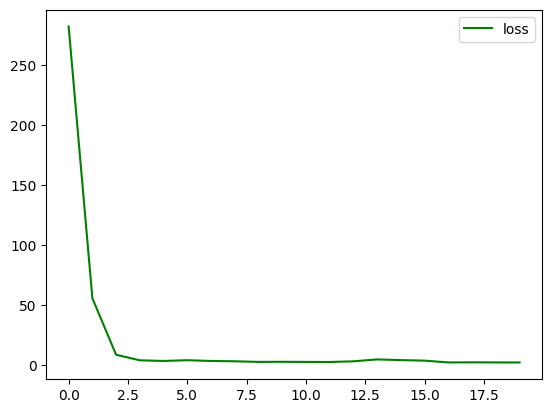

In [ ]:
plt.plot(history.history['loss'],'green', label="loss")
plt.legend()

In [ ]:
model.evaluate(validation_dataset,batch_size = validation_dataset.batch_size ,steps = validation_dataset.n // validation_dataset.batch_size)

2/2 [==============================] - 9s 837ms/step - loss: 2.1254 - tp: 120.0000 - fp: 8.0000 - tn: 120.0000 - fn: 8.0000 - accuracy: 0.9375 - precision: 0.9375 - recall: 0.9375 - auc: 0.9526


[2.1254162788391113,
 120.0,
 8.0,
 120.0,
 8.0,
 0.9375,
 0.9375,
 0.9375,
 0.95263671875]

In [ ]:
validation_dataset.reset()

In [ ]:
Y_pred = model.predict(validation_dataset,  workers=1)

3/3 [==============================] - 13s 4s/step


In [ ]:
y_pred = np.argmax(Y_pred ,  axis = 1)

In [ ]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1])

In [ ]:
validation_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
len(y_pred)

182

In [ ]:
len(validation_dataset.classes)

182

In [ ]:
res = tf.math.confusion_matrix(y_pred,validation_dataset.classes).numpy()

In [ ]:
confusion_matrix = pd.DataFrame(res,
                     index = classes,
                     columns = classes)

In [ ]:
confusion_matrix

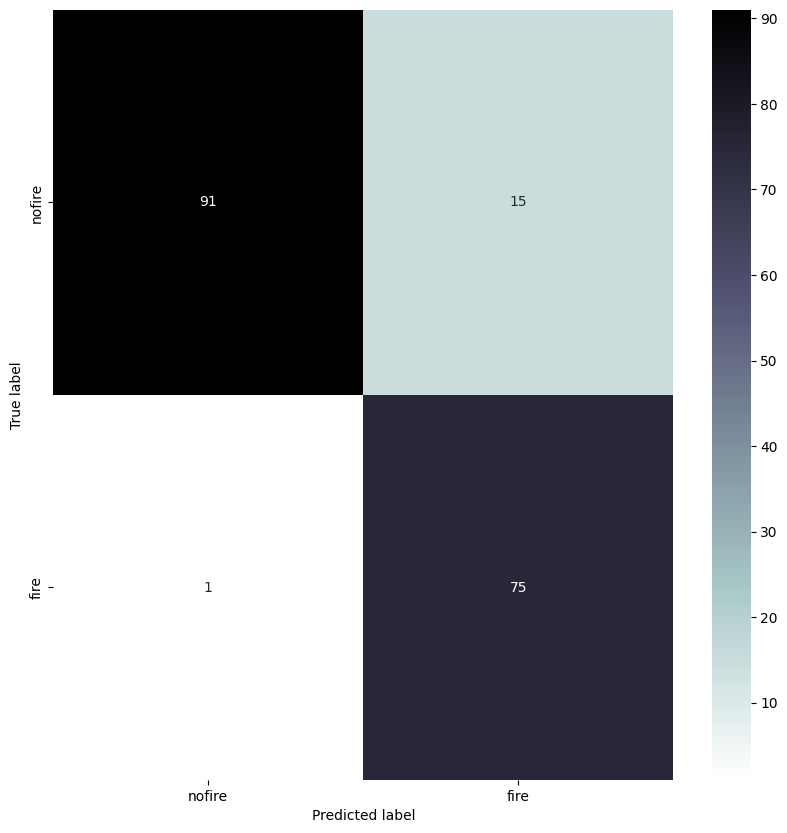

In [ ]:
import seaborn as sns
figure = plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, cmap=plt.cm.bone_r)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
classification_report = classification_report(validation_dataset.classes, y_pred,target_names = classes)
print(classification_report)

              precision    recall  f1-score   support

      nofire       0.86      0.99      0.92        92
        fire       0.99      0.83      0.90        90

    accuracy                           0.91       182
   macro avg       0.92      0.91      0.91       182
weighted avg       0.92      0.91      0.91       182



In [ ]:
from tensorflow.keras.models import save_model

save_model(model, "model_wildfire.h5")

<ipython-input-42-0693427c3e40>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, "model_wildfire.h5")


In [ ]:
from tensorflow.keras.models

model.save("model_wildfire.h5")

SyntaxError: ignored